In [1]:
from echopype.convert import Convert
from echopype import Process
import glob
import random
import matplotlib.pyplot as plt
import xarray as xr

import numpy as np

from os import path
import os


from echopy.processing import mask_seabed as  maskSB
from echopy.processing import mask_impulse as mIN
from echopy.processing import mask_shoals as mSH



from glider_azfp import load_glider, merge_glider_AZFP

In [2]:
%%time
# load in the glider data
# get from erddap first time, then save locally

gdata_local = './glider_data/'

# gdata_id = 'ru32-20190102T1317-profile-sci-rt'
gdata_id = 'ru32-20190102T1317-profile-sci-delayed'

# check if the glider data is already saved
if path.exists('./glider_data/'+ gdata_id + '.nc'):
    
    gl = xr.open_dataset(gdata_local + gdata_id + '.nc')
    
# if not, load from erddap and save it    
else:

    gl = load_glider(dataset_id = gdata_id)
    
    if not path.isdir(gdata_local):
        os.mkdir(gdata_local)
    
    # this is taking a really long time to write out (9.5 minutes)!
    # the file is like 250MB, why so long?

    gl.load().to_netcdf(gdata_local + gdata_id + '.nc')
    

# gl

CPU times: user 67 ms, sys: 15.4 ms, total: 82.4 ms
Wall time: 81 ms


# load an AZFP file

you'd want to build the loop below here

In [3]:
path_to_raw = './data/'

# alternativly, pick a random file
all_files = glob.glob(path_to_raw+'*.01A')
# a random file from the list (got to remove path and extention)
fname = random.choice(all_files)[7:-4]

# path to the 'fake' calibration file
calib_file = './data/NLB_test.XML'

print('random file used:')
print(fname + '.01A')

random file used:
19011800.01A


In [4]:

# fname = '19011711'
# fname = '19011717'
# fname = '19011709' #decent swarm, maybe bottom reflection?


# converts the raw AZFP data
# we are 'tricking' echopype with a fake .XML file
# the real files fail because there is no temperature data
# edit the './data/' parts so the path works for where you put the files
data_tmp = Convert(path_to_raw + fname + '.01A', calib_file)


# place to save processed files
savedir = './data_netcdfs/'

# converts to a netcdf we can use with xarray
data_tmp.raw2nc(save_path = savedir )


# read the converted data 

nc_path = savedir + fname + '.nc'

# process so you can get calibrated, clean, data 

ed = Process(nc_path)   # create a processing object

# need to figure out how much it matter that these vary a lot

ed.temperature = gl.potential_temperature.mean().values  
ed.salinity = gl.salinity.mean().values     
ed.pressure = gl.pressure.mean().values     # pressure in dbar
ed.recalculate_environment()  # recalculate related parameters

ed.calibrate()           # Sv

# lets remove the first few bins with ringdown?
ed.Sv.Sv[:,:,:100] = np.NaN

ed.remove_noise(SNR=2)        # denoise, this is adaptive! will change with the file! NOT WORKING NOW!



azfp = ed.Sv_clean


11:27:30 converting file 19011800.01A with NLB_test.XML, time of first ping 2019-Jan-18 00:00:02
Initialize using average temperature recorded by instrument
11:27:30  calibrating data in ./data_netcdfs/19011800.nc
11:27:30  Remove noise from Sv stored in memory.


In [5]:

# merge the glider and azfp data

ds = merge_glider_AZFP( gl, azfp, )

# ds

# processing with echopy

add some processing steps from the `echopy` package

try some:
1. seabed masking
1. impluse noise removal
1. swarm detection

In [6]:

# create a mask for the bottom
sf_mask = np.empty_like(ds.Sv)

j = 0
for f in ds.frequency:
#     sf_mask[j,:,:] = maskSB.ariza(ds.Sv.sel(frequency=f).data.T, ds.range[0,:,0].data,
#                       dc=3).T
    sf_mask[j,:,:] = maskSB.maxSv(ds.Sv.sel(frequency=f).data.T, ds.range[0,:,0].data.T,
                                  r0=0, r1=75, roff=0, thr=(-60, -80)).T
    j+=1

# create a bottom mask if any of the frequencies detect the bottom
seafloor_mask = np.any(sf_mask, axis=0)

ds.update({'seafloor_mask': (('ping_time', 'range_bin'), seafloor_mask)});

In [7]:
# create a swarm mask
# this takes a long time to run ...

swarm_mask = np.empty_like(ds.Sv)

j = 0
for f in ds.frequency:
    swarm_mask[j,:,:] = mSH.weill(ds.Sv.sel(frequency=f).where(~ds.seafloor_mask).data.T, 
                                  thr=-75, maxvgap=50, minvlen=0, minhlen=0)[0].T
#     swarm_mask[j,:,:] = mSH.echoview(ds.Sv.sel(frequency=f).where(~ds.seafloor_mask).data.T,
#                                     np.arange( len(ds.Sv.range_bin )+1),
#                                     np.arange(len(ds.Sv.ping_time)+1),
#                                     thr=-85,
#                                     mincan=(5, 5),
#                                     maxlink=(30, 2),
#                                     minsho=(30, 2) )[0].T
    

    j+=1
                                     
ds.update({'swarm_mask': (('frequency','ping_time', 'range_bin'),swarm_mask)}) ;                                                                  

# plot the results

Text(0.5, 1.0, 'Sv in swarms')

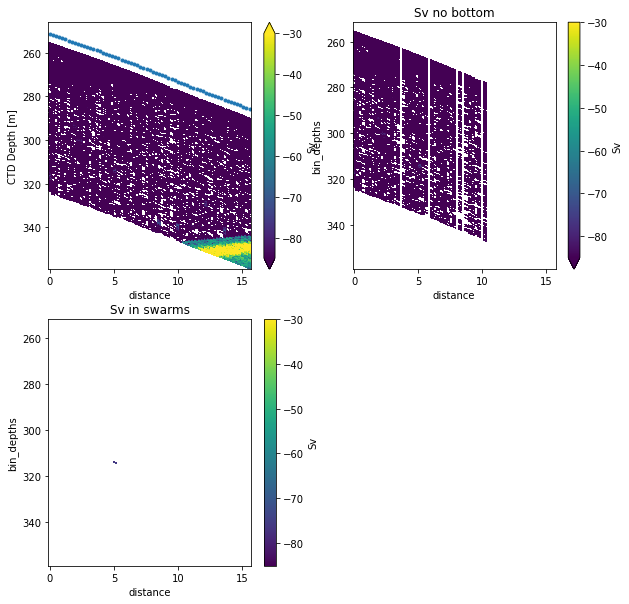

In [8]:
plt.figure(figsize=(10,10))

svmin = -85
svmax = -30

f = ds.frequency[1]

plt.subplot(221)
ds.Sv.sel(frequency =f ).plot(x="distance", 
                          y="bin_depths", yincrease=False, 
                         vmin = svmin, vmax= svmax)
ds.depth.plot(x="distance", marker='.', ls='')

plt.subplot(222)

ds.Sv.sel(frequency=f).where(~ds.seafloor_mask).plot(x="distance", 
                         y="bin_depths", yincrease=False, 
                         vmin = svmin, vmax= svmax)
plt.title('Sv no bottom')

plt.subplot(223)

ds.Sv.sel(frequency=f).where(ds.swarm_mask.sel(frequency=f)
                        ).plot(x="distance", 
                               y="bin_depths", yincrease=False, 
                         vmin = svmin, vmax= svmax)
plt.title('Sv in swarms')

# ds.bottom_depth.plot(marker='o', ls='')